In [1]:
import os
import requests
import uuid
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# 1. Configuración inicial
LOCAL_IMAGE_PATH = './repo_dataset'
TARGET_SIZE = (224, 224)
TARGET_SIZE_CHANNEL = (224, 224, 3)
BATCH_SIZE = 32

# Columnas de clases
LABEL_COLUMNS = ['direccion', 'fachada', 'envio', 'etiqueta']

#cargar csv y dividir en dev set y test set
# Load the dataset into a DataFrame
#CSV_PATH = '.\mobilnet-multi-label-solo-local.csv'
#CSV_PATH = '.\mobilnet-multi-label.csv'
#CSV_PATH = '.\mobilnet-multi-label-dev-test-50.csv'
CSV_PATH = '.\mobilnet-multi-label-train-80.csv'

In [3]:
def split_csv(input_file, train_output, test_output, train_size=0.8, random_state=42):
    """
    Divide un archivo CSV en dos conjuntos aleatorios con proporción especificada.
    
    Parámetros:
    input_file (str): Ruta del archivo CSV de entrada
    train_output (str): Ruta donde se guardará el archivo de entrenamiento (80%)
    test_output (str): Ruta donde se guardará el archivo de prueba (20%)
    train_size (float): Proporción para el conjunto de entrenamiento (default 0.8)
    random_state (int): Semilla para reproducibilidad (default 42)
    """
    
    # Leer el archivo CSV
    df = pd.read_csv(input_file)
    
    # Crear una máscara aleatoria para la división
    np.random.seed(random_state)
    mask = np.random.rand(len(df)) < train_size
    
    # Dividir el DataFrame
    train_df = df[mask]
    test_df = df[~mask]
    
    # Guardar los archivos
    train_df.to_csv(train_output, index=False)
    test_df.to_csv(test_output, index=False)
    
    # Imprimir información sobre la división
    print(f"Dataset original: {len(df)} filas")
    print(f"Conjunto de entrenamiento: {len(train_df)} filas ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Conjunto de prueba: {len(test_df)} filas ({len(test_df)/len(df)*100:.1f}%)")

In [4]:
'''
split_csv(
    input_file=CSV_PATH,
    train_output='.\mobilnet-multi-label-dev-test-50.csv',
    test_output='.\mobilnet-multi-label-test-50.csv',
    train_size=0.5
)
'''

sample_df = pd.read_csv('.\mobilnet-multi-label-dev-test-50.csv')
print(f'Length dataset {len(sample_df)}')

Length dataset 5424


In [5]:
# cargar las imagenes
def prepare_image(row, local_image_path, label_columns, target_size):
    # Preparar las etiquetas
    labels = row[label_columns].values.astype(int)
 
    try:
        # Cargar desde archivo local
        img_path = os.path.join(local_image_path, row['filename'])
        if os.path.exists(img_path):
            image = Image.open(img_path)
        elif pd.notna(row['urlAbsoluta']):    
             # Descargar la imagen desde la URL
             response = requests.get(row['urlAbsoluta'], stream=True, timeout=10)
             if response.status_code == 200:
                 image = Image.open(BytesIO(response.content))
                 #guardar local para el siguiente ciclo de entrenamiento/prueba
                 image.save(img_path)
    
        # Convertir a RGB (en caso de que la imagen esté en otro formato, como RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Redimensionar la imagen
        image = image.resize(target_size)  # Redimensionar a 224x224 para MobileNetV3
        
        # Convertir a un array de numpy y normalizar
        image = np.array(image) / 255.0  # Normalizar
        
        return image, np.array(labels)
    except:
        print(f'Error en: {img_path}')
        return None


def prepare_dataset(df, local_image_path, label_columns, target_size, max_workers=4):
    labels = []
    images = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Procesar cada fila del DataFrame
        futures = [executor.submit(prepare_image, row, local_image_path, label_columns, target_size) 
                   for _, row in df.iterrows()]
          
        # Recolectar resultados con barra de progreso
        for future in tqdm(futures, total=len(df)):
            result = future.result()
            if result is not None:
                img_array, img_labels = result
                images.append(img_array)
                labels.append(img_labels)

    # Convertir a arrays numpy
    X = np.array(images)
    y = np.array(labels)

    return X, y

def print_class_distribution(X, y, label_columns):
    print(f"Dataset preparado con {len(X)} imágenes")
    print(f"Distribución de clases:")
    for i, col in enumerate(label_columns):
        positive_samples = np.sum(y[:, i])
        percentage = (positive_samples / len(y)) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{len(y)})")

In [6]:
print('prepare_dataset...')

X,y = prepare_dataset(sample_df, LOCAL_IMAGE_PATH, LABEL_COLUMNS, TARGET_SIZE)   
print(f'X={X.shape}, y={y.shape}')

print('prepare_dataset OK')

print_class_distribution(X, y, LABEL_COLUMNS)

prepare_dataset...


 15%|███████████▍                                                                  | 798/5424 [00:04<00:24, 187.31it/s]

Error en: ./repo_dataset\663000000000582300_2024022009150840.jpg


100%|█████████████████████████████████████████████████████████████████████████████| 5424/5424 [00:20<00:00, 268.49it/s]


X=(5423, 224, 224, 3), y=(5423, 4)
prepare_dataset OK
Dataset preparado con 5423 imágenes
Distribución de clases:
direccion: 45.69% (2478/5423)
fachada: 47.83% (2594/5423)
envio: 40.37% (2189/5423)
etiqueta: 32.73% (1775/5423)


In [7]:
X_train = X
y_train = y

sample_df_test = pd.read_csv('.\mobilnet-multi-label-test-50.csv')
X_test,y_test = prepare_dataset(sample_df_test, LOCAL_IMAGE_PATH, LABEL_COLUMNS, TARGET_SIZE)   
print(f'X_test={X_test.shape}, y_test={y_test.shape}')

100%|█████████████████████████████████████████████████████████████████████████████| 2808/2808 [00:13<00:00, 204.82it/s]


X_test=(2808, 224, 224, 3), y_test=(2808, 4)


In [13]:
# Dividir el dataset en dev=50% y test=50%
def split_dataset(X, y, test_size=0.2, random_state=42):
    return train_test_split(
            X, y,
            test_size=test_size,
            random_state=random_state,
            stratify=y.sum(axis=1)  # Estratificar por número total de etiquetas
        )


print('split_dataset...')
# Dividir en train y test
X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.5)

print(f'X_train: {len(X_train)}, y_train: {len(y_train)}, X_test: {len(X_test)}, y_test {len(y_test)}')

print('split_dataset. OK')

print_class_distribution(X_train, y_train, LABEL_COLUMNS)

print('liberarndo X y y')
del X
del y

split_dataset...
X_train: 4198, y_train: 4198, X_test: 4199, y_test 4199
split_dataset. OK
Dataset preparado con 4198 imágenes
Distribución de clases:
direccion: 37.64% (1580/4198)
fachada: 39.61% (1663/4198)
envio: 49.40% (2074/4198)
etiqueta: 39.02% (1638/4198)
liberarndo X y y


In [17]:
class MultiLabelSMOTE:
    def __init__(self, k_neighbors=5, target_samples=500, random_state=None, output_dir='synthetic_images', batch_size=100):
        self.k_neighbors = k_neighbors
        self.target_samples = target_samples
        self.random_state = random_state
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.csv_path = os.path.join(output_dir, 'metadata.csv')
        
        os.makedirs(output_dir, exist_ok=True)
        self._init_csv()

    def _init_csv(self):
        if not os.path.exists(self.csv_path):
            columns = ['filename', 'urlAbsoluta', 'diraccion', 'fachada', 'envio', 'etiqueta']
            pd.DataFrame(columns=columns).to_csv(self.csv_path, index=False)

    def _save_image_and_metadata(self, image_array, y_labels, batch_counter):
        """Guarda imagen y actualiza CSV por lotes"""
        batch_data = []
        
        for i in range(len(image_array)):
            # Generar nombre único para el archivo
            unique_id = uuid.uuid4()
            filename = f"synthetic_{unique_id}.jpg"
            filepath = os.path.abspath(os.path.join(self.output_dir, filename))
            
            # Guardar imagen
            img = Image.fromarray((image_array[i] * 255).astype(np.uint8))
            img.save(filepath)
            
            # Extraer etiquetas (asumiendo orden: diraccion, fachada, envio, etiqueta)
            labels = y_labels[i]
            row = {
                'filename': filename,
                'urlAbsoluta': filepath,
                'diraccion': int(labels[0]),
                'fachada': int(labels[1]),
                'envio': int(labels[2]),
                'etiqueta': int(labels[3])
            }
            
            batch_data.append(row)
        
        # Guardar lote en CSV
        if batch_data:
            df = pd.DataFrame(batch_data)
            df.to_csv(self.csv_path, mode='a', header=False, index=False)
    
    def _reshape_for_knn(self, X):
        original_shape = X.shape
        if len(original_shape) > 2:
            n_samples = original_shape[0]
            return X.reshape(n_samples, -1), original_shape
        return X, original_shape

    def _restore_shape(self, X, original_shape):
        if len(original_shape) > 2:
            return X.reshape((-1,) + original_shape[1:])
        return X

    def _balance_label(self, X, y, label_idx):
        idx = np.where(y[:, label_idx] == 1)[0]
        X_label = X[idx]
        y_label = y[idx]
        
        if len(X_label) >= self.target_samples:
            return np.empty((0,) + X_label.shape[1:]), np.empty((0,) + y_label.shape[1:])

        X_reshaped, original_shape = self._reshape_for_knn(X_label)
        n_needed = self.target_samples - len(X_label)
        
        knn = NearestNeighbors(n_neighbors=self.k_neighbors)
        knn.fit(X_reshaped)
        distances, indices = knn.kneighbors(X_reshaped)
        
        synthetic_X = []
        synthetic_y = []
        
        for _ in range(n_needed):
            i = np.random.randint(0, len(X_label))
            neighbor_idx = np.random.choice(indices[i])
            gap = np.random.uniform(0, 1)
            
            synthetic = X_reshaped[i] + gap * (X_reshaped[neighbor_idx] - X_reshaped[i])
            synthetic_X.append(synthetic)
            synthetic_y.append(y_label[i])

        synthetic_X = np.array(synthetic_X)
        synthetic_X = self._restore_shape(synthetic_X, original_shape)
        
        return synthetic_X, np.array(synthetic_y)
    
    def fit_resample(self, X, y):
        np.random.seed(self.random_state)
        batch_counter = 0
        
        for label_idx in range(y.shape[1]):
            X_synth, y_synth = self._balance_label(X, y, label_idx)
            
            if len(X_synth) > 0:
                num_batches = int(np.ceil(len(X_synth) / self.batch_size))
                
                for batch_num in range(num_batches):
                    start = batch_num * self.batch_size
                    end = (batch_num + 1) * self.batch_size
                    
                    batch_X = X_synth[start:end]
                    batch_y = y_synth[start:end]
                    
                    self._save_image_and_metadata(batch_X, batch_y, batch_counter)
                    batch_counter += 1
                    del batch_X, batch_y  # Liberar memoria

        # Leer y combinar datos manteniendo solo únicos
        df = pd.read_csv(self.csv_path)
        df_unique = df.drop_duplicates(subset=['diraccion', 'fachada', 'envio', 'etiqueta', 'urlAbsoluta'])
        df_unique.to_csv(self.csv_path, index=False)
        
        return X, y  # Devuelve originales + sintéticos vía CSV


    def get_combined_data(self):
        """Carga todos los datos desde el CSV y las imágenes"""
        df = pd.read_csv(self.csv_path)
        image_arrays = []
        
        for _, row in df.iterrows():
            img = Image.open(row['urlAbsoluta'])
            image_arrays.append(np.array(img))
        
        X_combined = np.array(image_arrays) / 255.0
        y_combined = df[['diraccion', 'fachada', 'envio', 'etiqueta']].values
        
        return X_combined, y_combined

In [18]:
# 2. Cargar modelo base (MobileNetV3 Large)
# Aplicar SMOTE adaptado
print('MultiLabelSMOTE...')
# calcular la mínima cantidad de muestrar a generar con un grado de tolerancia
# Suma por columna para obtener la frecuencia de cada etiqueta
frecuencias = np.sum(y_train, axis=0)
# Obtener el valor máximo (la cantidad máxima de veces que aparece una etiqueta)
max_frecuencia = np.max(frecuencias)
# Si quieres saber cuál etiqueta es la que más aparece
etiqueta_mas_comun = np.argmax(frecuencias) 

print(f'Frecuencia de cada etiqueta: {frecuencias}')
print(f'La etiqueta que más aparece es la {etiqueta_mas_comun} con {max_frecuencia} apariciones')
max_frecuencia = int(max_frecuencia - (max_frecuencia * 0.05))
print(f'Umbral de generación: {max_frecuencia}')


# Configurar con batch_size pequeño para baja memoria
mlsmote = MultiLabelSMOTE(
    target_samples=max_frecuencia,
    output_dir='./synthetic_data',
    batch_size=500  # Ajustar según memoria disponible
)


# mlsmote = MultiLabelSMOTE(target_samples=max_frecuencia, k_neighbors=3, random_state=42)
X_bal, y_bal = mlsmote.fit_resample(X_train, y_train)

print(f'X_bal: {len(X_bal)}, y_bal: {len(y_bal)}')

# Verificar balanceo
print("Conteo original por clase:", y_train.sum(axis=0))
print("Conteo balanceado por clase:", y_bal.sum(axis=0))

print_class_distribution(X_bal, y_bal, LABEL_COLUMNS)
print('MultiLabelSMOTE OK')

MultiLabelSMOTE...
Frecuencia de cada etiqueta: [ 607  654 1852 1416]
La etiqueta que más aparece es la 2 con 1852 apariciones
Umbral de generación: 1759
X_bal: 2823, y_bal: 2823
Conteo original por clase: [ 607  654 1852 1416]
Conteo balanceado por clase: [ 607  654 1852 1416]
Dataset preparado con 2823 imágenes
Distribución de clases:
direccion: 21.50% (607/2823)
fachada: 23.17% (654/2823)
envio: 65.60% (1852/2823)
etiqueta: 50.16% (1416/2823)
MultiLabelSMOTE OK


In [8]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, local_image_path, label_columns, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        self.local_image_path = local_image_path
        self.label_columns = label_columns
        
    def __len__(self):
        return len(self.dataframe) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.dataframe.iloc[batch_indices]
        
        images = []
        labels = []
        
        for _, row in batch_data.iterrows():
            result = prepare_image(row, self.local_image_path, self.label_columns, self.img_size)

            if result is not None:
                img, label = result
                images.append(img)
                labels.append(label)
            else: 
                print('Continuando por:', row['filename'])
                print('Continuando...')
                continue
            
        return np.array(images), np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
# 1. Calcular pesos de clases adaptativos
def calculate_class_weights(labels, alpha=0.7, smooth=1e-6):
    class_counts = np.sum(labels, axis=0) + smooth
    weights = (1 / class_counts) ** alpha  # Mayor énfasis en clases minoritarias
    return weights / np.max(weights)  # Normalización a [0, 1]

def weighted_binary_crossentropy(class_weights):
    # Convertir class_weights a tensor, en caso de que aún no lo sea
    class_weights = tf.constant(class_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # Convertir las etiquetas a float32 para evitar problemas de tipo
        y_true = tf.cast(y_true, tf.float32)
        # Calcula la pérdida binaria por cada etiqueta
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Multiplica la pérdida de cada clase por su peso correspondiente.
        # Se asume que y_true y bce tienen forma (batch_size, num_classes)
        weighted_bce = bce * class_weights
        # Se promedia la pérdida a lo largo de las clases y muestras
        return tf.reduce_mean(weighted_bce)
    
    return loss

def build_model(input_shape, num_classes):
    # 1. Cargar el modelo base pre-entrenado (MobileNetV3Large) sin la capa de clasificación final
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=TARGET_SIZE_CHANNEL,
        include_preprocessing=True,  # Aplica el preprocesamiento interno
        include_top=False,  # Excluimos la parte de clasificación original
        weights='imagenet'
    )
    base_model.trainable = False  # Congelamos las capas del modelo base

    # 2. Construir la nueva arquitectura agregando una cabeza de clasificación para multi-label
    inputs = tf.keras.Input(shape=TARGET_SIZE_CHANNEL)
    # Preprocesamiento específico para MobileNetV3
    x = layers.Rescaling(scale=255.0)(inputs)  # Escalar de [0,1] a [0,255]
   
    # Es posible que necesites redimensionar o normalizar si tus imágenes no cumplen el formato:
    x = base_model(x)
    
    # Capas base del modelo (ejemplo)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Desactiva el 50% de las neuronas en entrenamiento
    
    # Capa de salida multi-label
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

In [10]:
# Función para graficar las métricas de entrenamiento y validación
def plot_training_history(history):
    metrics = ['binary_accuracy', 'precision', 'recall']
    plt.figure(figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(history.history[metric], label='Entrenamiento')
        plt.plot(history.history['val_' + metric], label='Validación')
        plt.title(metric.capitalize())
        plt.xlabel('Épocas')
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

build_model...
build_model OK
loss...
loss OK
compile...
compile OK
fit inicial...
Length dataset 5424
Epoch 1/15
 86/169 [==============>...............] - ETA: 53s - loss: 0.2766 - binary_accuracy: 0.8619 - precision: 0.8188 - recall: 0.8581Error en: ./repo_dataset\663000000000582300_2024022009150840.jpg
Continuando por: 663000000000582300_2024022009150840.jpg
Continuando...
169/169 [==============================] - 183s 1s/step - loss: 0.2394 - binary_accuracy: 0.8845 - precision: 0.8403 - recall: 0.8923 - val_loss: 0.1768 - val_binary_accuracy: 0.9199 - val_precision: 0.8878 - val_recall: 0.9178 - lr: 0.0010
Epoch 2/15
 25/169 [===>..........................] - ETA: 1:29 - loss: 0.1674 - binary_accuracy: 0.9300 - precision: 0.8897 - recall: 0.9497Error en: ./repo_dataset\663000000000582300_2024022009150840.jpg
Continuando por: 663000000000582300_2024022009150840.jpg
Continuando...
169/169 [==============================] - 171s 1s/step - loss: 0.1564 - binary_accuracy: 0.9337 - pr

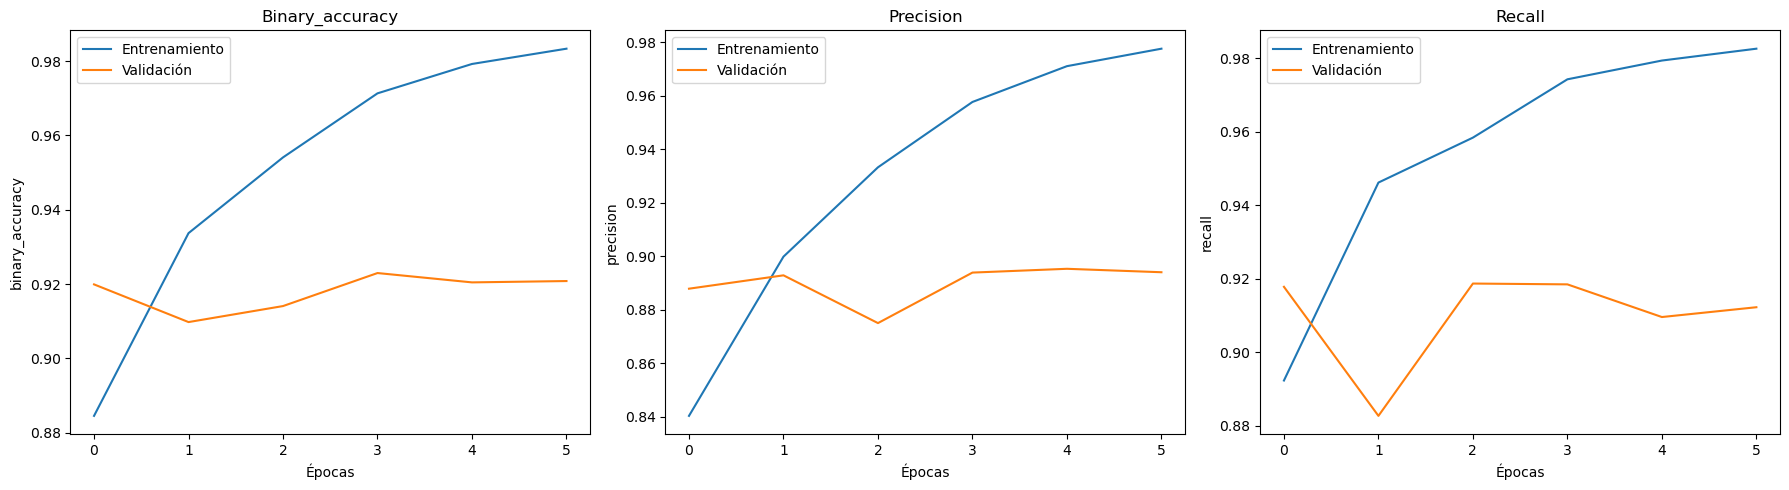

In [14]:
# 1. Construcción del modelo con MobileNetV3
print('build_model...')
X_bal = X_train
y_bal = y_train
model = build_model(input_shape=X_bal.shape[1:], num_classes=len(LABEL_COLUMNS))
print('build_model OK')

print('loss...')
# Ejemplo de uso:
class_weights = calculate_class_weights(y_bal, alpha=0.7)
loss_fn = weighted_binary_crossentropy(class_weights)
print('loss OK')

# Optimizador con learning rate adaptativo
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# 2. Compilación del modelo
print('compile...')
model.compile(
    optimizer=optimizer,
    loss=loss_fn,  # Loss estándar para multi-label
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
print('compile OK')


print('fit inicial...')
# Crear generadores
train_df = pd.read_csv('.\mobilnet-multi-label-dev-test-50.csv')
val_df = pd.read_csv('.\mobilnet-multi-label-test-50.csv')
print(f'Length dataset {len(train_df)}')

train_gen = CustomDataGenerator(train_df, BATCH_SIZE, TARGET_SIZE, LOCAL_IMAGE_PATH, label_columns=LABEL_COLUMNS)
val_gen = CustomDataGenerator(val_df, BATCH_SIZE, TARGET_SIZE, LOCAL_IMAGE_PATH, label_columns=LABEL_COLUMNS, shuffle=False)

# 3. Entrenamiento inicial (solo capas nuevas)
initial_epochs = 15
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

print('fit inicial OK')
# Llamada a la función para mostrar las gráficas
plot_training_history(history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          276512    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          1849

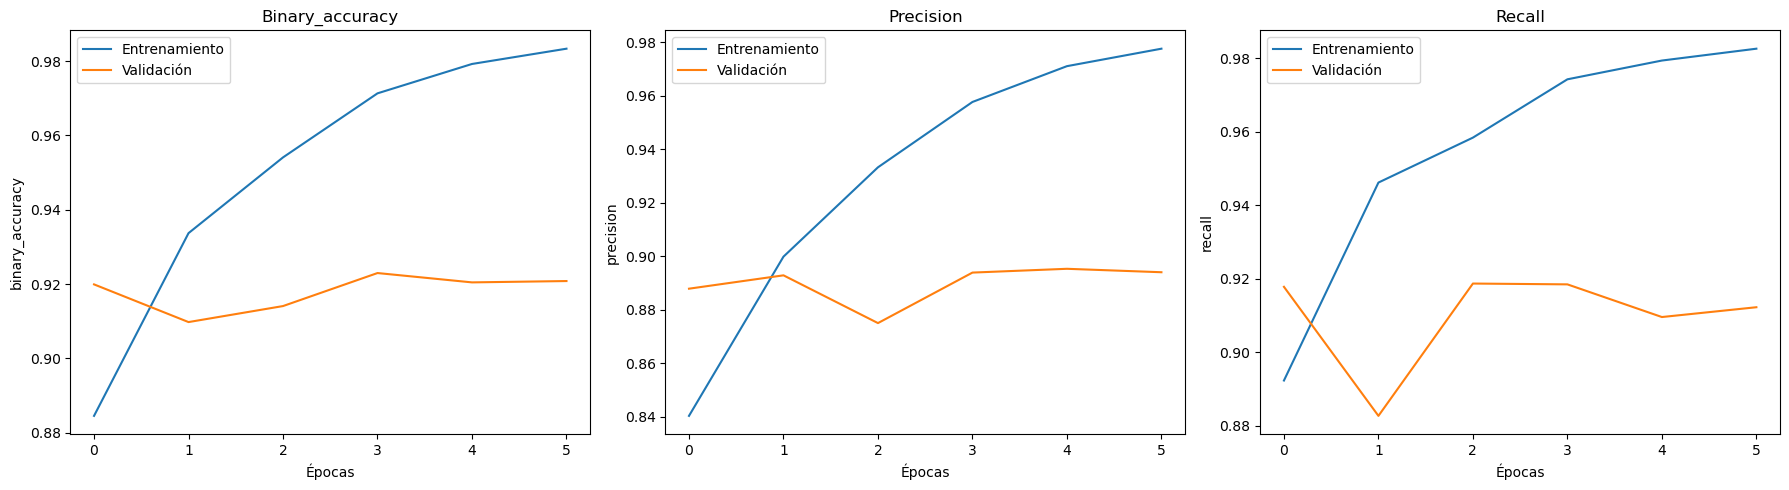

fit OK
save...
save OK


In [15]:
model.summary()

# Ver arquitectura detallada
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# 4. Fine-tuning (descongelar capas superiores)
# Descongelar las últimas 15 capas del modelo base
base_model = model.layers[2]  # Índice de la capa MobileNetV3
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Recompilar con learning rate más bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Entrenar con fine-tuning
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

print('fit...')
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

# Llamada a la función para mostrar las gráficas
plot_training_history(history)
print('fit OK')

# Guardar el modelo entrenado
print('save...')
model.save("mobilenetv3_classifier.v.7.keras")
print('save OK')

In [16]:
from sklearn.metrics import classification_report

print('predict...')
# Dataset de validación sin aumentos
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Generar predicciones
y_pred = model.predict(val_dataset)
y_pred = (y_pred > 0.5).astype(int)
print('predict OK')

# Reporte detallado por clase
print(classification_report(
    y_test,
    y_pred,
    target_names=LABEL_COLUMNS,
    zero_division=0
))

predict...
88/88 [==============================] - 38s 390ms/step
predict OK
              precision    recall  f1-score   support

   direccion       0.77      0.87      0.82       583
     fachada       0.85      0.88      0.87       648
       envio       0.94      0.97      0.95      1880
    etiqueta       0.88      0.90      0.89      1421

   micro avg       0.88      0.92      0.90      4532
   macro avg       0.86      0.91      0.88      4532
weighted avg       0.89      0.92      0.90      4532
 samples avg       0.89      0.93      0.89      4532



1/1 [==============================] - 2s 2s/step


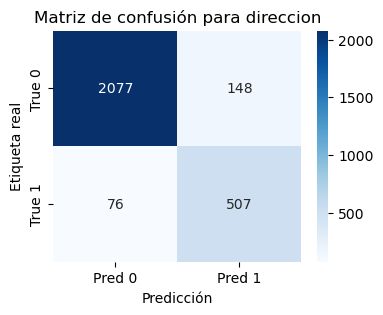

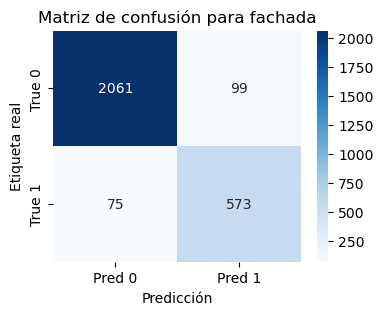

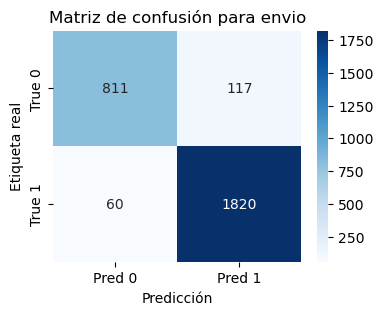

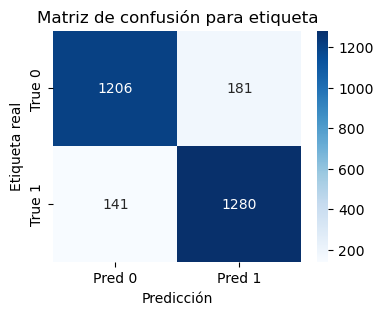

In [17]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Acumula las etiquetas verdaderas y las predicciones en listas
y_true_list = []
y_pred_list = []

# Itera sobre el dataset de validación
for x_batch, y_batch in val_dataset:
    # Genera las predicciones para el batch
    preds = model.predict(x_batch)
    # Convierte las probabilidades a etiquetas binarias (umbral de 0.5, ajústalo si es necesario)
    preds_binary = (preds > 0.5).astype(int)
    
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(preds_binary)

# Concatena todos los batches en arreglos completos
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calcula la matriz de confusión para cada clase
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Recorre y muestra la matriz de confusión de cada clase
for i, cm in enumerate(mcm):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Pred 0", "Pred 1"], 
                yticklabels=["True 0", "True 1"])
    plt.title(f"Matriz de confusión para {LABEL_COLUMNS[i]}")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción")
    plt.show()
